# Project 2: Sentiment Analysis From Audio Recordings

--------------------------------------------------------------------------------

Group Members:  
**Abdul Moez** (F2020266109)  
**Ammara Malik** (F2020266540)  
**Syed Arsalan Askari Naqvi** (F2020266116)

--------------------------------------------------------------------------------

**Libraries**

Importing all the necessary libraries

In [2]:
import pandas as pd
import numpy as np

import os
import sys

import librosa
import librosa.display
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.model_selection import train_test_split

import keras
from keras.callbacks import ReduceLROnPlateau
from keras.models import Sequential
from keras.layers import Dense, Conv1D, MaxPooling1D, Flatten, Dropout, BatchNormalization
from keras.utils import np_utils, to_categorical
from keras.callbacks import ModelCheckpoint


from IPython.display import Audio

from glob import glob

from itertools import cycle

import warnings
if not sys.warnoptions:
    warnings.simplefilter("ignore")
warnings.filterwarnings("ignore", category=DeprecationWarning) 

Mouting my Google Drive (as dataset is stored there)

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


**Dataset**

Getting all audio recordings from dataset

In [4]:
audio_recs = glob('/content/drive/MyDrive/Colab Notebooks/Datasets/AudioWAV/*.wav')
audio_recs

['/content/drive/MyDrive/Colab Notebooks/Datasets/AudioWAV/1079_TIE_SAD_XX.wav',
 '/content/drive/MyDrive/Colab Notebooks/Datasets/AudioWAV/1080_DFA_SAD_XX.wav',
 '/content/drive/MyDrive/Colab Notebooks/Datasets/AudioWAV/1079_WSI_SAD_XX.wav',
 '/content/drive/MyDrive/Colab Notebooks/Datasets/AudioWAV/1079_TIE_NEU_XX.wav',
 '/content/drive/MyDrive/Colab Notebooks/Datasets/AudioWAV/1079_TIE_ANG_XX.wav',
 '/content/drive/MyDrive/Colab Notebooks/Datasets/AudioWAV/1079_TIE_DIS_XX.wav',
 '/content/drive/MyDrive/Colab Notebooks/Datasets/AudioWAV/1079_TSI_DIS_XX.wav',
 '/content/drive/MyDrive/Colab Notebooks/Datasets/AudioWAV/1079_WSI_FEA_XX.wav',
 '/content/drive/MyDrive/Colab Notebooks/Datasets/AudioWAV/1080_DFA_FEA_XX.wav',
 '/content/drive/MyDrive/Colab Notebooks/Datasets/AudioWAV/1079_TSI_SAD_XX.wav',
 '/content/drive/MyDrive/Colab Notebooks/Datasets/AudioWAV/1079_TIE_FEA_XX.wav',
 '/content/drive/MyDrive/Colab Notebooks/Datasets/AudioWAV/1080_DFA_HAP_XX.wav',
 '/content/drive/MyDrive/Col

Playing one audio recording to test

In [5]:
Audio(audio_recs[0])

Using load() function from librosa library to get waveform and sampling rate of the above audio recording, then plotting the waveform

In [6]:
y, sr = librosa.load(audio_recs[0]) # y 'waveform' & sr 'sampling rate'

<Axes: >

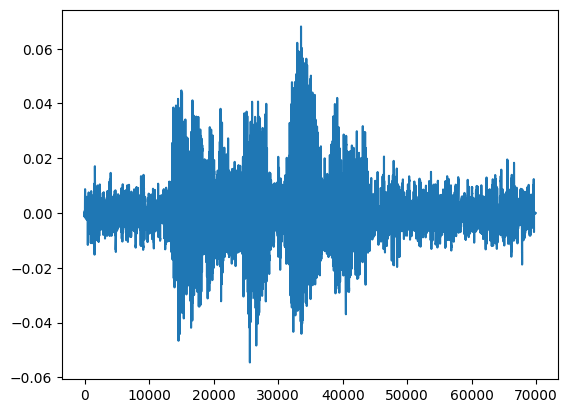

In [7]:
pd.Series(y).plot()

In [6]:
!pip install noisereduce

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


Filtering above audio recording due to noise

In [9]:
from scipy.io import wavfile
import noisereduce as nr
# load data
temp_rec=audio_recs[0]
rate, data = wavfile.read(temp_rec)
# perform noise reduction
reduced_noise = nr.reduce_noise(y=data, sr=rate)
wavfile.write("filtered_temp_rec.wav", rate, reduced_noise)

In [10]:
Audio("filtered_temp_rec.wav")

Plotting the noiseless recording

<Axes: >

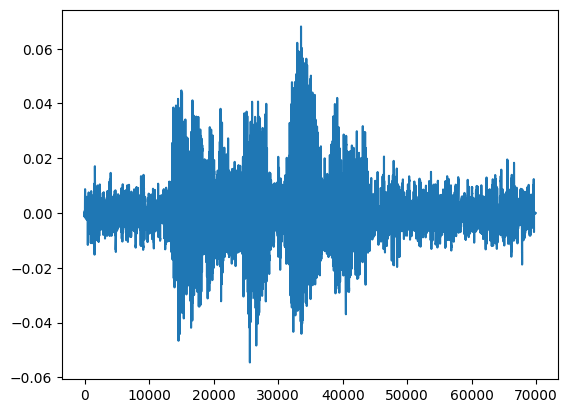

In [11]:
y, sr = librosa.load(temp_rec)
pd.Series(y).plot()

Creating CREMA dataframe and making two columns for emotion type and path of file

In [8]:
CREMA = '/content/drive/MyDrive/Colab Notebooks/Datasets/AudioWAV/'
crema_directory_list = os.listdir(CREMA)

file_emotion = []
file_path = []

for file in crema_directory_list:
    # storing file paths
    file_path.append(CREMA + file)
    # storing file emotions
    part=file.split('_')
    if part[2] == 'SAD':
        file_emotion.append('sad')
    elif part[2] == 'ANG':
        file_emotion.append('angry')
    elif part[2] == 'DIS':
        file_emotion.append('disgust')
    elif part[2] == 'FEA':
        file_emotion.append('fear')
    elif part[2] == 'HAP':
        file_emotion.append('happy')
    elif part[2] == 'NEU':
        file_emotion.append('neutral')
    else:
        file_emotion.append('Unknown')
        
# dataframe for emotion of files
emotion_df = pd.DataFrame(file_emotion, columns=['Emotions'])

# dataframe for path of files.
path_df = pd.DataFrame(file_path, columns=['Path'])
Crema_df = pd.concat([emotion_df, path_df], axis=1)
Crema_df.head()

,Emotions,Path
0,sad,/content/drive/MyDrive/Colab Notebooks/Dataset...
1,sad,/content/drive/MyDrive/Colab Notebooks/Dataset...
2,sad,/content/drive/MyDrive/Colab Notebooks/Dataset...
3,neutral,/content/drive/MyDrive/Colab Notebooks/Dataset...
4,angry,/content/drive/MyDrive/Colab Notebooks/Dataset...


Creating csv file for dataframe we made above

In [9]:
Crema_df.to_csv("CREMA-D.csv",index=False)
Crema_df

,Emotions,Path
0,sad,/content/drive/MyDrive/Colab Notebooks/Dataset...
1,sad,/content/drive/MyDrive/Colab Notebooks/Dataset...
2,sad,/content/drive/MyDrive/Colab Notebooks/Dataset...
3,neutral,/content/drive/MyDrive/Colab Notebooks/Dataset...
4,angry,/content/drive/MyDrive/Colab Notebooks/Dataset...
...,...,...
7437,sad,/content/drive/MyDrive/Colab Notebooks/Dataset...
7438,disgust,/content/drive/MyDrive/Colab Notebooks/Dataset...
7439,happy,/content/drive/MyDrive/Colab Notebooks/Dataset...
7440,fear,/content/drive/MyDrive/Colab Notebooks/Dataset...


**Data Visualization**

Displaying the count of emotions in dataset

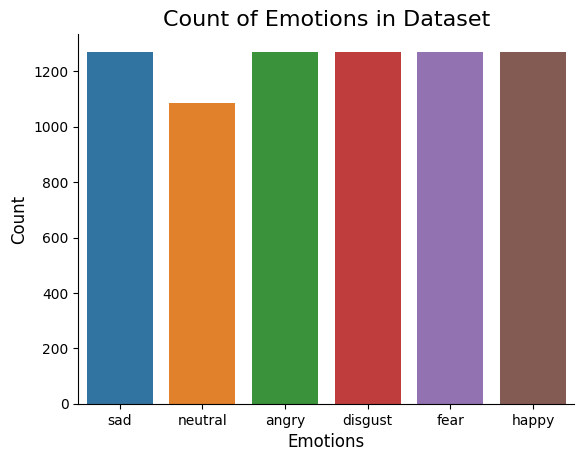

In [10]:
plt.title('Count of Emotions in Dataset', size=16)
sns.countplot(x=Crema_df.Emotions)
plt.ylabel('Count', size=12)
plt.xlabel('Emotions', size=12)
sns.despine(top=True, right=True, left=False, bottom=False)
plt.show()

In [20]:
path = np.array(Crema_df.Path[Crema_df.Emotions=='fear'])[1]
path

'/content/drive/MyDrive/Colab Notebooks/Datasets/AudioWAV/1080_DFA_FEA_XX.wav'

Defining functions to display waveplots and spectograms of the audio recordings

In [11]:
def create_waveplot(data, sr, e):
    plt.figure(figsize=(10, 3))
    plt.title('Waveplot for audio with {} emotion'.format(e), size=15)
    librosa.display.waveshow(data, sr=sr)
    plt.show()

In [12]:
def create_spectrogram(data, sr, e):
    X = librosa.stft(data)
    Xdb = librosa.amplitude_to_db(abs(X))
    plt.figure(figsize=(12, 3))
    plt.title('Spectrogram for audio with {} emotion'.format(e), size=15)
    librosa.display.specshow(Xdb, sr=sr, x_axis='time', y_axis='hz')   
    plt.colorbar()

Visualizing a 'fear' emotion audio recording

In [24]:
emotion='fear'
path = np.array(Crema_df.Path[Crema_df.Emotions==emotion])[1]
data, sampling_rate = librosa.load(path)
Audio(path)

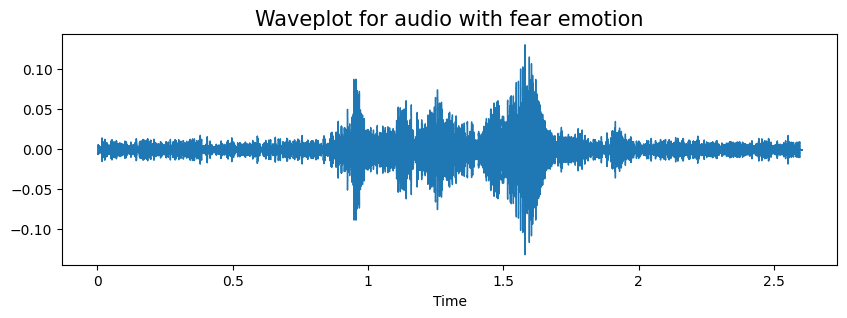

In [25]:
create_waveplot(data, sampling_rate, emotion)

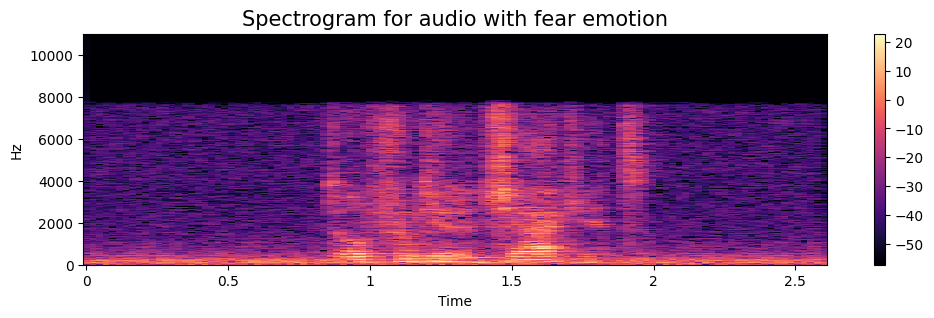

In [26]:
create_spectrogram(data, sampling_rate, emotion)

Visualizing a 'angry' emotion audio recording

In [27]:
emotion='angry'
path = np.array(Crema_df.Path[Crema_df.Emotions==emotion])[1]
data, sampling_rate = librosa.load(path)
Audio(path)

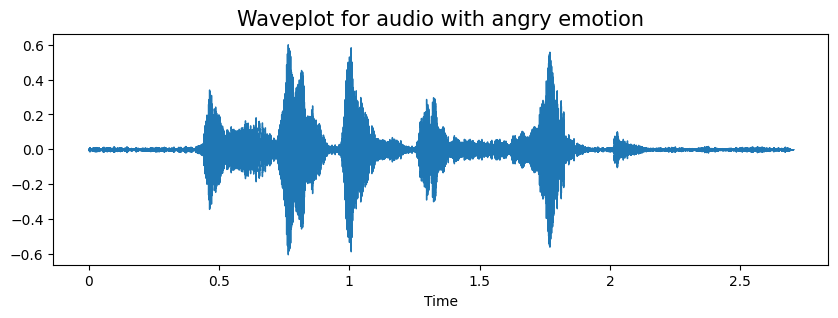

In [28]:
create_waveplot(data, sampling_rate, emotion)

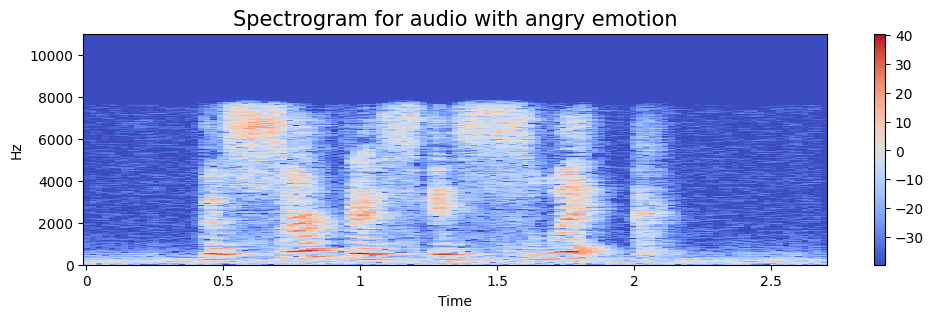

In [29]:
create_spectrogram(data, sampling_rate, emotion)

Visualizing a 'sad' emotion audio recording

In [30]:
emotion='sad'
path = np.array(Crema_df.Path[Crema_df.Emotions==emotion])[1]
data, sampling_rate = librosa.load(path)
Audio(path)

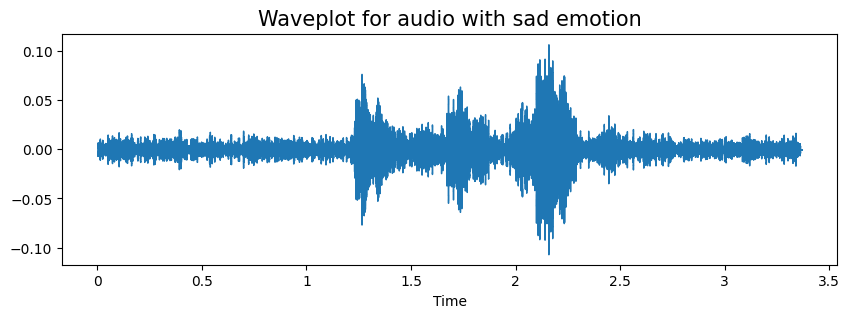

In [31]:
create_waveplot(data, sampling_rate, emotion)

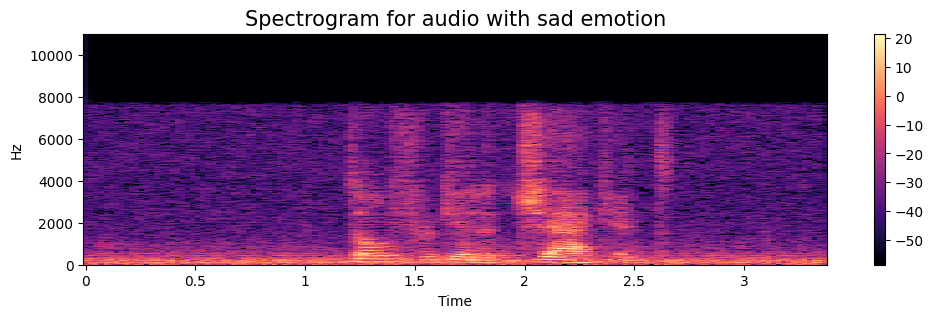

In [32]:
create_spectrogram(data, sampling_rate, emotion)

Visualizing a 'happy' emotion audio recording

In [13]:
emotion='happy'
path = np.array(Crema_df.Path[Crema_df.Emotions==emotion])[1]
data, sampling_rate = librosa.load(path)
Audio(path)

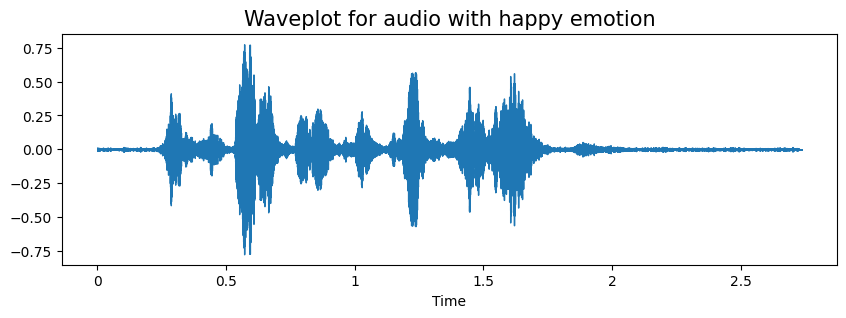

In [34]:
create_waveplot(data, sampling_rate, emotion)

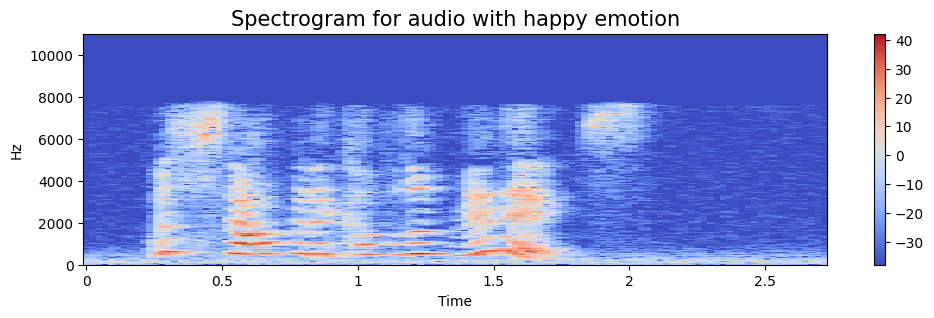

In [35]:
create_spectrogram(data, sampling_rate, emotion)

**Data Augmentation**

Defining functions for augmentation techniques

In [15]:
def noise(data):
    noise_amp = 0.035*np.random.uniform()*np.amax(data)
    data = data + noise_amp*np.random.normal(size=data.shape[0])
    return data

def stretch(data, rate=0.8):
    return librosa.effects.time_stretch(data, rate=rate)

def shift(data):
    shift_range = int(np.random.uniform(low=-5, high = 5)*1000)
    return np.roll(data, shift_range)

def pitch(data, sampling_rate, pitch_factor=0.7):
    return librosa.effects.pitch_shift(data, sr=sampling_rate, n_steps=int(pitch_factor * 12))

In [17]:
# taking any example and checking for techniques.
path = np.array(Crema_df.Path)[1]
SAMPLE_RATE = 22050
data, _ = librosa.load(path, sr=SAMPLE_RATE)

Simple audio

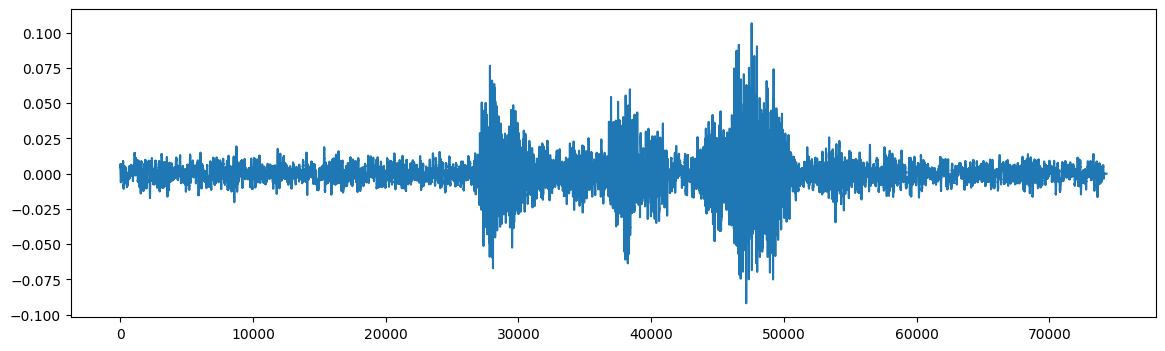

In [42]:
plt.figure(figsize=(14,4))
plt.plot(data)
Audio(path)

Noise Injection

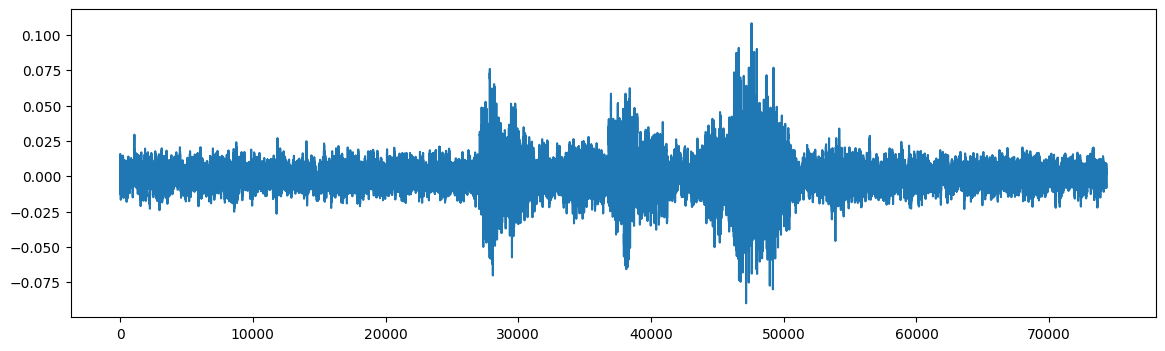

In [43]:
x = noise(data)
plt.figure(figsize=(14,4))
plt.plot(x)
Audio(x, rate=SAMPLE_RATE)

Stretching

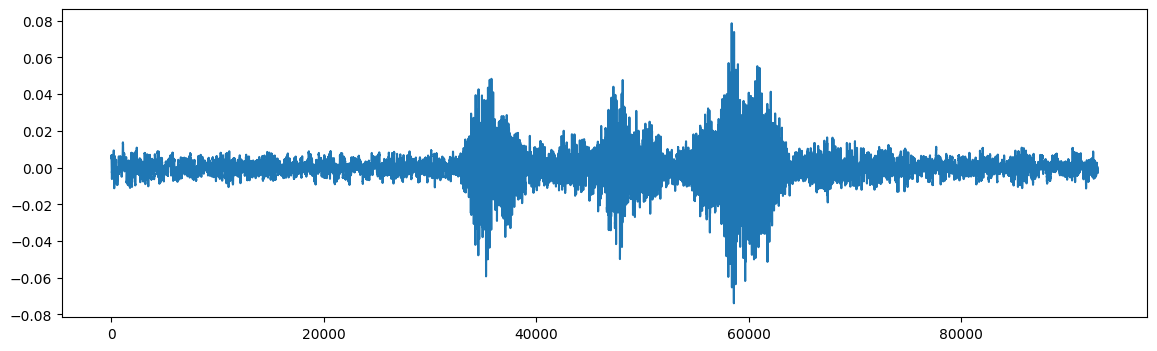

In [18]:
x = stretch(data)
plt.figure(figsize=(14,4))
plt.plot(x)
Audio(x, rate=SAMPLE_RATE)

Shifting

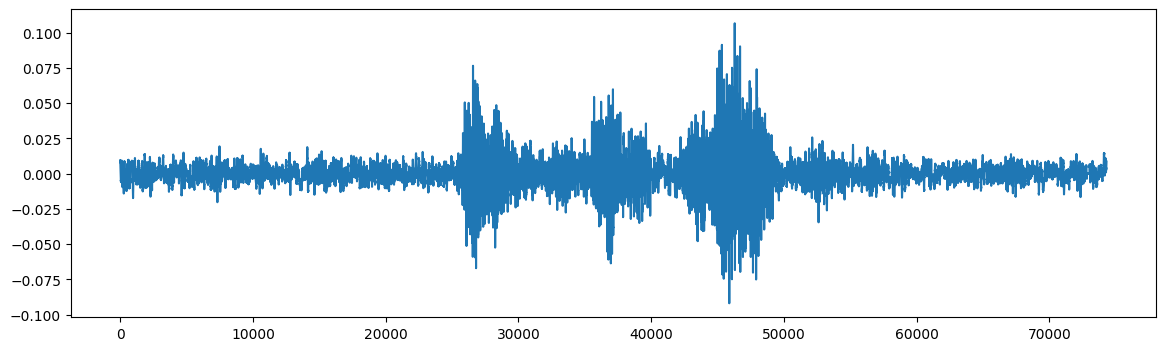

In [46]:
x = shift(data)
plt.figure(figsize=(14,4))
plt.plot(x)
Audio(x, rate=SAMPLE_RATE)

Pitch

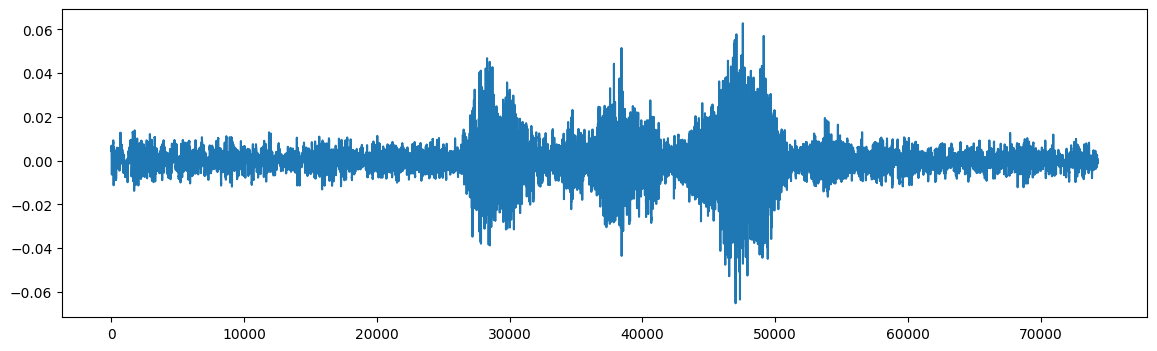

In [47]:
x = pitch(data, SAMPLE_RATE)
plt.figure(figsize=(14,4))
plt.plot(x)
Audio(x, rate=SAMPLE_RATE)

From the above augmentation techniques we will be using noise, stretching and some pitching for our project

**Feature Extraction**

We are going to extract following 5 features:


*   Zero Crossing Rate
*   Chroma_stft
*   MFCC
*   Root Mean Square
*   MelSpectogram



In [48]:
def extract_features(data):
    # Zero Crossing Rate
    result = np.array([])
    zcr = np.mean(librosa.feature.zero_crossing_rate(y=data).T, axis=0)
    result=np.hstack((result, zcr)) # stacking horizontally

    # Chroma_stft
    stft = np.abs(librosa.stft(data))
    chroma_stft = np.mean(librosa.feature.chroma_stft(S=stft, sr=SAMPLE_RATE).T, axis=0)
    result = np.hstack((result, chroma_stft)) # stacking horizontally

    # MFCC
    mfcc = np.mean(librosa.feature.mfcc(y=data, sr=SAMPLE_RATE).T, axis=0)
    result = np.hstack((result, mfcc)) # stacking horizontally

    # Root Mean Square
    rms = np.mean(librosa.feature.rms(y=data).T, axis=0)
    result = np.hstack((result, rms)) # stacking horizontally

    # MelSpectogram for the training of model
    mel = np.mean(librosa.feature.melspectrogram(y=data, sr=SAMPLE_RATE).T, axis=0)
    result = np.hstack((result, mel)) # stacking horizontally
    
    return np.array(result)

In [49]:
def load_file(path):
    # duration and offset are used to take care of the no audio in start and the ending of each audio files as seen above.
    data, _ = librosa.load(path, duration=2.5, offset=0.6, sr=SAMPLE_RATE)
    
    return data

In [50]:
def augment_and_extract_features(path):
    data = load_file(path)

    # without augmentation
    res1 = extract_features(data)
    result = np.vstack((np.array(res1), ))
    
    # data with noise
    noise_data = noise(data)
    res2 = extract_features(noise_data)
    result = np.vstack((result, res2)) # stacking vertically
    
    # data with stretching and pitching
    new_data = stretch(data)
    data_stretch_pitch = pitch(new_data, SAMPLE_RATE)
    res3 = extract_features(data_stretch_pitch)
    result = np.vstack((result, res3)) # stacking vertically
    
    return result

In [51]:
from tqdm import tqdm

X_path, y_emotion = Crema_df.Path, Crema_df.Emotions
x_train_path, x_test_path, y_train_emotion, y_test_emotion = train_test_split(X_path, y_emotion, random_state=0, shuffle=True)

In [52]:
X_train, y_train = [], []

for path, emotion in tqdm(zip(x_train_path, y_train_emotion)):
    feature = augment_and_extract_features(path)
    for ele in feature:
        X_train.append(ele)
        y_train.append(emotion)

3381it [31:21,  2.06it/s]/usr/local/lib/python3.10/dist-packages/librosa/core/pitch.py:102: UserWarning: Trying to estimate tuning from empty frequency set.
  return pitch_tuning(
5581it [51:34,  1.80it/s]


In [53]:
X_test, y_test = [], []

for path, emotion in tqdm(zip(x_test_path, y_test_emotion)):
    feature = augment_and_extract_features(path)
    for ele in feature:
        X_test.append(ele)
        y_test.append(emotion)

1861it [17:27,  1.78it/s]


Data augmentation and feature extraction done for each of the audio files and files are saved

**Data Preperation**

In [54]:
# As this is a multiclass classification problem onehotencoding our Y.
encoder = OneHotEncoder()
y_train = encoder.fit_transform(np.array(y_train).reshape(-1,1)).toarray()
y_test = encoder.fit_transform(np.array(y_test).reshape(-1,1)).toarray()

In [55]:
# scaling our data with sklearn's Standard scaler
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)
X_train.shape, y_train.shape, X_test.shape, y_test.shape

((16743, 162), (16743, 6), (5583, 162), (5583, 6))

In [56]:
# making our data compatible to model.
X_train = np.expand_dims(X_train, axis=2)
X_test = np.expand_dims(X_test, axis=2)
X_train.shape, y_train.shape, X_test.shape, y_test.shape

((16743, 162, 1), (16743, 6), (5583, 162, 1), (5583, 6))

**Modelling**

In [57]:
model=Sequential()
model.add(Conv1D(256, kernel_size=5, strides=1, padding='same', activation='relu', input_shape=(X_train.shape[1], 1)))
model.add(MaxPooling1D(pool_size=5, strides = 2, padding = 'same'))

model.add(Conv1D(256, kernel_size=5, strides=1, padding='same', activation='relu'))
model.add(MaxPooling1D(pool_size=5, strides = 2, padding = 'same'))

model.add(Conv1D(128, kernel_size=5, strides=1, padding='same', activation='relu'))
model.add(MaxPooling1D(pool_size=5, strides = 2, padding = 'same'))
model.add(Dropout(0.2))

model.add(Conv1D(64, kernel_size=5, strides=1, padding='same', activation='relu'))
model.add(MaxPooling1D(pool_size=5, strides = 2, padding = 'same'))

model.add(Flatten())
model.add(Dense(units=32, activation='relu'))
model.add(Dropout(0.3))

model.add(Dense(units=6, activation='softmax'))
model.compile(optimizer = 'adam' , loss = 'categorical_crossentropy' , metrics = ['accuracy'])

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 162, 256)          1536      
                                                                 
 max_pooling1d (MaxPooling1D  (None, 81, 256)          0         
 )                                                               
                                                                 
 conv1d_1 (Conv1D)           (None, 81, 256)           327936    
                                                                 
 max_pooling1d_1 (MaxPooling  (None, 41, 256)          0         
 1D)                                                             
                                                                 
 conv1d_2 (Conv1D)           (None, 41, 128)           163968    
                                                                 
 max_pooling1d_2 (MaxPooling  (None, 21, 128)          0

In [58]:
rlrp = ReduceLROnPlateau(monitor='loss', factor=0.4, verbose=0, patience=2, min_lr=0.0000001)
history=model.fit(X_train, y_train, batch_size=64, epochs=50, validation_data=(X_test, y_test), callbacks=[rlrp])

Epoch 1/50
262/262 [==============================] - 144s 534ms/step - loss: 1.6129 - accuracy: 0.3069 - val_loss: 1.5210 - val_accuracy: 0.3812 - lr: 0.0010
Epoch 2/50
262/262 [==============================] - 129s 492ms/step - loss: 1.5384 - accuracy: 0.3579 - val_loss: 1.5012 - val_accuracy: 0.3701 - lr: 0.0010
Epoch 3/50
262/262 [==============================] - 130s 495ms/step - loss: 1.5068 - accuracy: 0.3715 - val_loss: 1.4583 - val_accuracy: 0.3885 - lr: 0.0010
Epoch 4/50
262/262 [==============================] - 130s 496ms/step - loss: 1.4892 - accuracy: 0.3836 - val_loss: 1.4361 - val_accuracy: 0.4001 - lr: 0.0010
Epoch 5/50
262/262 [==============================] - 129s 492ms/step - loss: 1.4695 - accuracy: 0.3949 - val_loss: 1.4362 - val_accuracy: 0.4075 - lr: 0.0010
Epoch 6/50
262/262 [==============================] - 127s 487ms/step - loss: 1.4511 - accuracy: 0.4016 - val_loss: 1.4131 - val_accuracy: 0.4198 - lr: 0.0010
Epoch 7/50
262/262 [==========================

Plotting the training and testing loss and training and testing accuracy

175/175 [==============================] - 8s 46ms/step - loss: 1.9133 - accuracy: 0.4335
Accuracy of our model on test data :  43.345871567726135 %


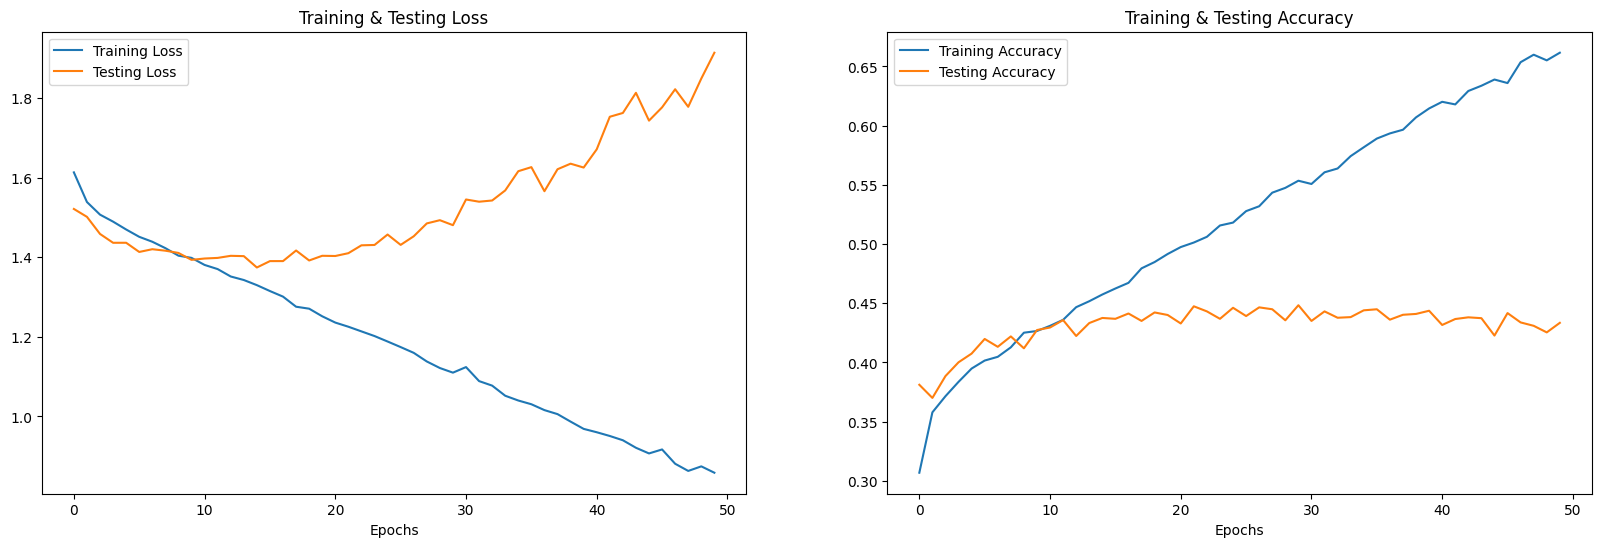

In [59]:
print("Accuracy of our model on test data : " , model.evaluate(X_test,y_test)[1]*100 , "%")

epochs = [i for i in range(50)]
fig , ax = plt.subplots(1,2)
train_acc = history.history['accuracy']
train_loss = history.history['loss']
test_acc = history.history['val_accuracy']
test_loss = history.history['val_loss']

fig.set_size_inches(20,6)
ax[0].plot(epochs , train_loss , label = 'Training Loss')
ax[0].plot(epochs , test_loss , label = 'Testing Loss')
ax[0].set_title('Training & Testing Loss')
ax[0].legend()
ax[0].set_xlabel("Epochs")

ax[1].plot(epochs , train_acc , label = 'Training Accuracy')
ax[1].plot(epochs , test_acc , label = 'Testing Accuracy')
ax[1].set_title('Training & Testing Accuracy')
ax[1].legend()
ax[1].set_xlabel("Epochs")
plt.show()

Predicting the emotions on the given test data

In [60]:
# predicting on test data.
pred_test = model.predict(X_test)
y_pred = encoder.inverse_transform(pred_test)

y_test = encoder.inverse_transform(y_test)

175/175 [==============================] - 8s 46ms/step


In [61]:
df = pd.DataFrame(columns=['Predicted Labels', 'Actual Labels'])
df['Predicted Labels'] = y_pred.flatten()
df['Actual Labels'] = y_test.flatten()

df.head(10)

,Predicted Labels,Actual Labels
0,fear,sad
1,neutral,sad
2,neutral,sad
3,disgust,angry
4,angry,angry
5,disgust,angry
6,sad,sad
7,sad,sad
8,neutral,sad
9,fear,fear


Displaying the confusion matrix and classification report of our model

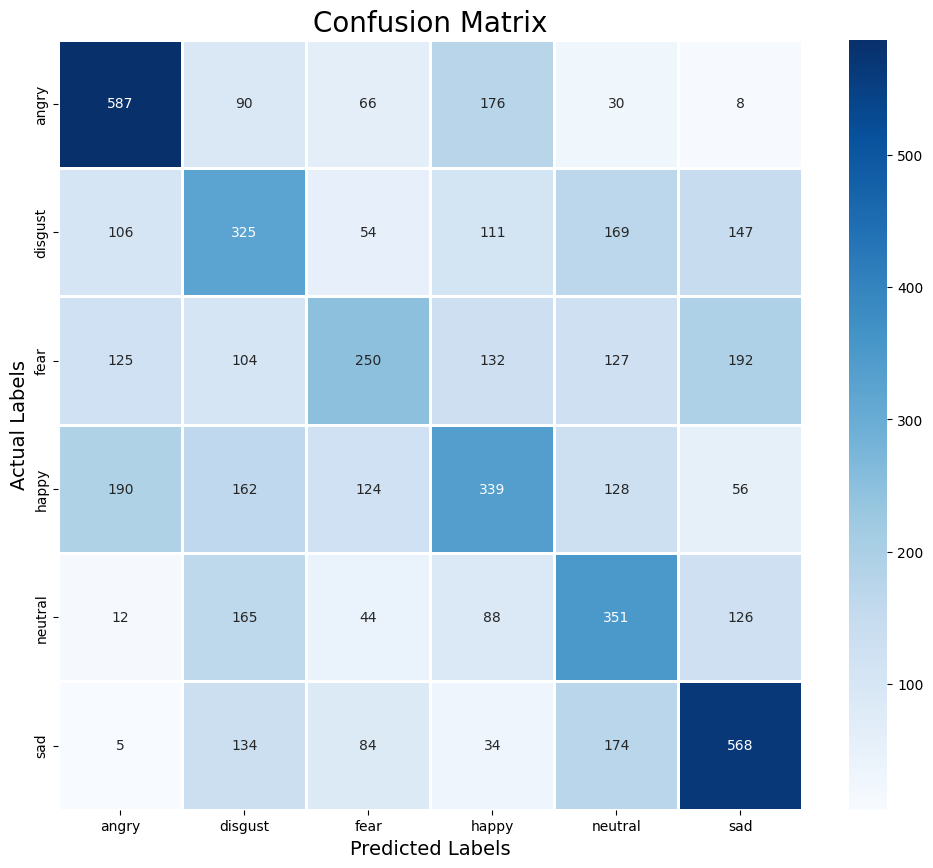

In [62]:
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize = (12, 10))
cm = pd.DataFrame(cm , index = [i for i in encoder.categories_] , columns = [i for i in encoder.categories_])
sns.heatmap(cm, linecolor='white', cmap='Blues', linewidth=1, annot=True, fmt='')
plt.title('Confusion Matrix', size=20)
plt.xlabel('Predicted Labels', size=14)
plt.ylabel('Actual Labels', size=14)
plt.show()

In [63]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

       angry       0.57      0.61      0.59       957
     disgust       0.33      0.36      0.34       912
        fear       0.40      0.27      0.32       930
       happy       0.39      0.34      0.36       999
     neutral       0.36      0.45      0.40       786
         sad       0.52      0.57      0.54       999

    accuracy                           0.43      5583
   macro avg       0.43      0.43      0.43      5583
weighted avg       0.43      0.43      0.43      5583

